# Multi-Class Classification on "Computer Security" Category

## 1. Imports

In [1]:
import ast
import random
import re
import string
from collections import Counter
from pathlib import Path
from typing import Union, Any

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from numpy import asarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from wordcloud import WordCloud

from preprocess_functions import build_tree, extract_keys, map_targets
from utils import CalibratedLabelRankClassifier, ChainOfClassifiers, LabelPowersetClassifier, \
    assess_models, prune_and_subsample, ConditionalDependencyNetwork, MetaBinaryRelevance, tokenizer_transform, \
    replace_text_components, clean_text, lemmatize_text, remove_stopwords

[nltk_data] Downloading package punkt to /home/cela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cela/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cela/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/cela/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-02-12 11:12:38.238182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow 

## 2. Configurations & Constants

### Global Configuration Constants

In [12]:
OVERWRITE = False
RETRAIN = True
RANDOM_STATE = 42
MODEL_LEVEL = 'computer_security'

### Set Random Seeds

In [3]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Testing Parameters

In [4]:
TEST_SIZE = 2e-1

### Category Mappings

In [5]:
FIX_TARGETS = {
    #'network security': 'network security',
    'antivirus and malware': 'antivirus and malware'
}

### Base Models

In [6]:
BASE_CLASSIFIERS = {
    'logistic_regression': LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight='balanced'),
    #'gaussian_nb': GaussianNB(),
    #'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'random_forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'xgb': xgb.XGBClassifier(random_state=RANDOM_STATE),
}

### Directory Paths

In [7]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

### Dataset & Model Paths

In [8]:
BINARY_PROBLEMS_DIR = MODELS_DIR / 'binary_problems'
ENSEMBLES_DIR = MODELS_DIR / 'ensembles'
MULTICLASS_PROBLEMS_DIR = MODELS_DIR / 'multiclass_problems'
GLOVE_DIR = MODELS_DIR / 'glove-embeddings'
GLOVE_6B_300D_TXT = GLOVE_DIR / 'glove.6B.300d.txt'

DATASET_DIR = DATA_DIR / 'tweets-dataset-for-cyberattack-detection'
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_train.csv'

COMPUTER_SECURITY_PKL = MODELS_DIR / f'{MODEL_LEVEL}.pkl'
BR_PKL = BINARY_PROBLEMS_DIR / f'br_{MODEL_LEVEL}.pkl'
CLR_PKL = BINARY_PROBLEMS_DIR / f'clr_{MODEL_LEVEL}.pkl'
CC_PKL = BINARY_PROBLEMS_DIR / f'cc_{MODEL_LEVEL}.pkl'

LP_PKL = MULTICLASS_PROBLEMS_DIR / f'lp_{MODEL_LEVEL}.pkl'
PST_PKL = MULTICLASS_PROBLEMS_DIR / f'pst_{MODEL_LEVEL}.pkl'

CDN_PKL = ENSEMBLES_DIR / f'pkl_{MODEL_LEVEL}.pkl'
MBR_PKL = ENSEMBLES_DIR / f'mbr_{MODEL_LEVEL}.pkl'

### Loading Models

In [9]:
br = joblib.load(filename=BR_PKL) if BR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
clr = joblib.load(filename=CLR_PKL) if CLR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cc = joblib.load(filename=CC_PKL) if CC_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
lp = joblib.load(filename=LP_PKL) if LP_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
pst = joblib.load(filename=PST_PKL) if PST_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
cdn = joblib.load(filename=CDN_PKL) if CDN_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)
mbr = joblib.load(filename=MBR_PKL) if MBR_PKL.exists() else dict.fromkeys(BASE_CLASSIFIERS.keys(), None)

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest for the category 'computer security' are:
1. antivirus and malware
2. network security

In [13]:
threat_tweets = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    .query(expr='relevant == True')
    .drop(labels=[
        'relevant', '_id', 'date',
        'id', 'tweet', 'type',
        'annotation', 'urls', 'destination_url',
        'valid_certificate'
    ], axis=1)
    .dropna(subset=['text'], ignore_index=True)
)
threat_tweets['text'] = [replace_text_components(t) for t in threat_tweets['text']]
threat_tweets['text'] = [clean_text(t) for t in threat_tweets['text']]
threat_tweets['text'] = [lemmatize_text(t) for t in threat_tweets['text']]
threat_tweets['text'] = [remove_stopwords(t) for t in threat_tweets['text']]

threat_tweets = threat_tweets[
    threat_tweets["watson_list"].apply(lambda x: ' '.join(MODEL_LEVEL.split(sep='_')) in x)
].reset_index(drop=True)

print(f"Threat Tweets: {len(threat_tweets)}")
threat_tweets.head()

Threat Tweets: 4653


,text,watson,watson_list,target
0,protonmail ddos attack british bomb threat tee...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]
1,watch get first vulnerability anyone know see ...,"{'society': {'unrest and war': {}}, 'technolog...","[society, unrest and war, technology and compu...",[antivirus and malware]
2,uk teen involve protonmail ddos attack arrest,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]
3,francis prince thangasamy share 2018 threat re...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]
4,eoeo virus removal restore infected computer e...,{'technology and computing': {'computer securi...,"[technology and computing, computer security, ...",[antivirus and malware]


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [14]:
all_words = ' '.join(threat_tweets['text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('vulnerability', 1761), ('ddos', 888), ('attack', 652), ('ransomware', 511), ('security', 459), ('injection', 415), ('sql', 389), ('new', 351), ('exploit', 343), ('attacker', 269)]


#### 4.1.2. Word Cloud

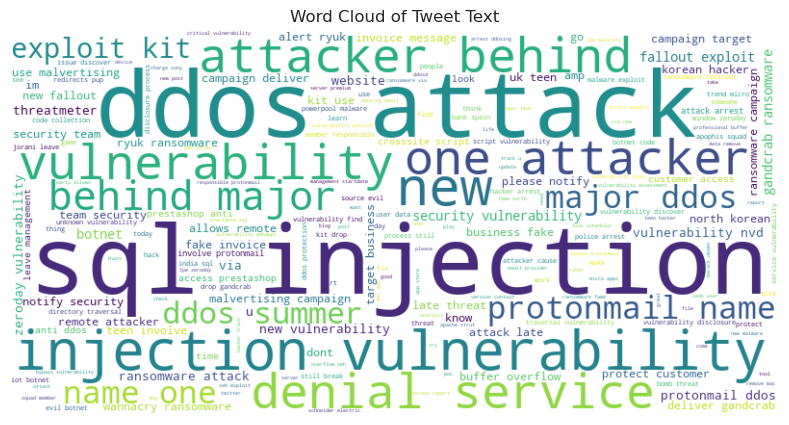

In [15]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text=' '.join(threat_tweets['text']))

plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

#### 4.1.3. Text Length Distribution

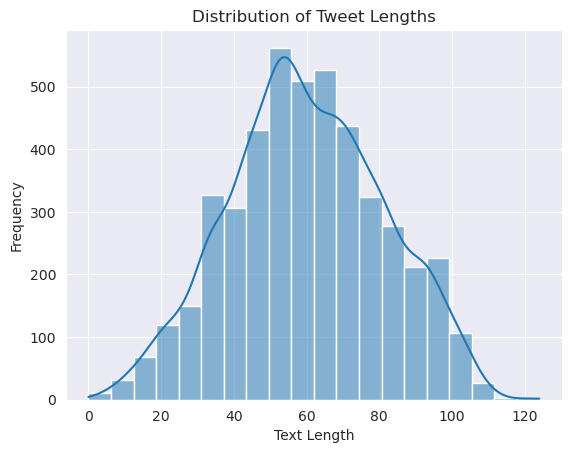

In [16]:
threat_tweets['text_length'] = threat_tweets['text'].apply(func=len)
sns.histplot(
    data=threat_tweets['text_length'],
    bins=20,
    kde=True
)
plt.title(label='Distribution of Tweet Lengths')
plt.xlabel(xlabel='Text Length')
plt.ylabel(ylabel='Frequency')
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [17]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in threat_tweets['watson_list'] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 4653), ('computer security', 4653), ('antivirus and malware', 3412), ('network security', 1698), ('software', 1545), ('hardware', 736), ('computer', 634), ('society', 633), ('databases', 611), ('business and industrial', 517)]


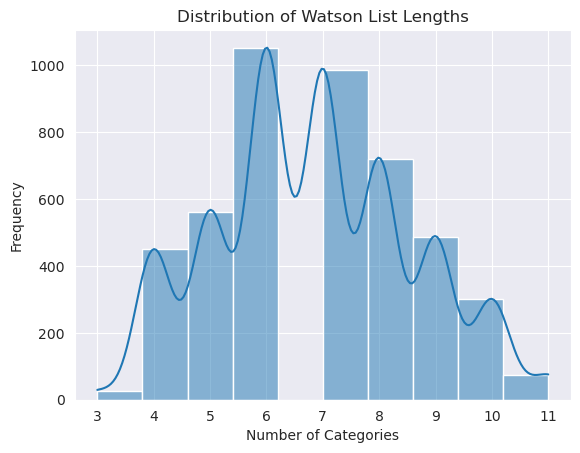

In [18]:
# Category Depth Analysis
threat_tweets['watson_list_length'] = threat_tweets['watson_list'].apply(func=len)

sns.histplot(
    data=threat_tweets['watson_list_length'],
    bins=10,
    kde=True
)

plt.title(label='Distribution of Watson List Lengths')
plt.xlabel(xlabel='Number of Categories')
plt.ylabel(ylabel='Frequency')
plt.show()

In [19]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in threat_tweets['watson_list']:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 4653), (('technology and computing', 'antivirus and malware'), 3412), (('computer security', 'antivirus and malware'), 3412), (('technology and computing', 'network security'), 1698), (('computer security', 'network security'), 1698), (('technology and computing', 'software'), 1545), (('computer security', 'software'), 1056), (('antivirus and malware', 'software'), 779), (('technology and computing', 'hardware'), 736), (('technology and computing', 'computer'), 634)]


In [20]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('computer', 5621), ('technology', 4653), ('antivirus', 3412), ('network', 1733), ('software', 1546), ('hardware', 736), ('society', 633), ('databases', 611), ('business', 556), ('law,', 516), ('crime', 475), ('personal', 366), ('art', 334), ('health', 330), ('science', 328), ('operating', 289), ('assault', 268), ('programming', 254), ('hobbies', 224), ('law', 194), ('consumer', 185), ('finance', 179), ('police', 178), ('networking', 174), ('weather', 165), ('meteorological', 158), ('internet', 152), ('disorders', 152), ('javascript', 150), ('government', 147), ('flood', 145), ('vpn', 139), ('property', 136), ('sports', 135), ('home', 135), ('bank', 133), ('disease', 131), ('mental', 131), ('games', 124), ('movies', 123), ('legal', 118), ('food', 111), ('panic', 109), ('music', 98), ('windows', 94), ('role', 93), ('java', 92), ('energy', 87), ('travel', 82), ('game', 80), ('shopping', 79), ('linux', 77), ('xbox', 75), ('legislation', 70), ('company', 65

### 4.4. Target Analysis

Target Frequencies:
antivirus and malware: 3412
other: 1241


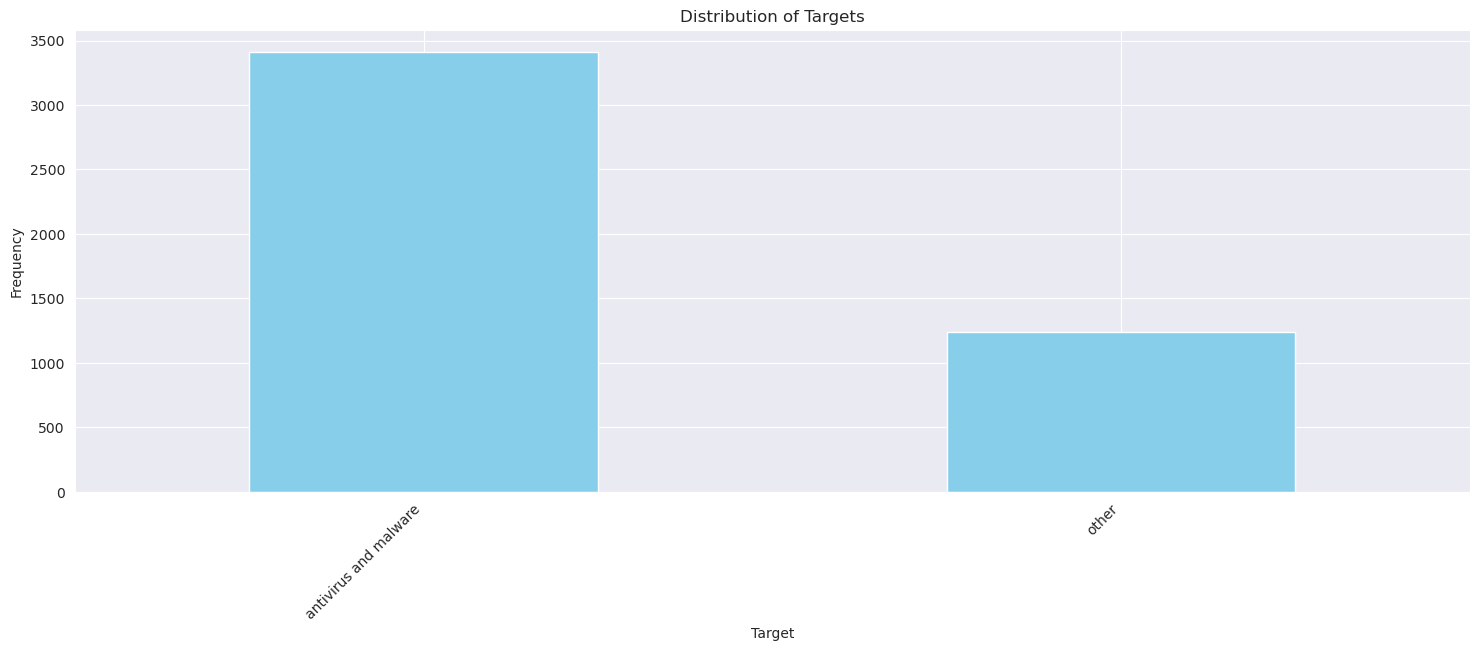

In [21]:
class_freq = Counter([item[0] for item in threat_tweets['target']])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('antivirus and malware',): 3412
('other',): 1241


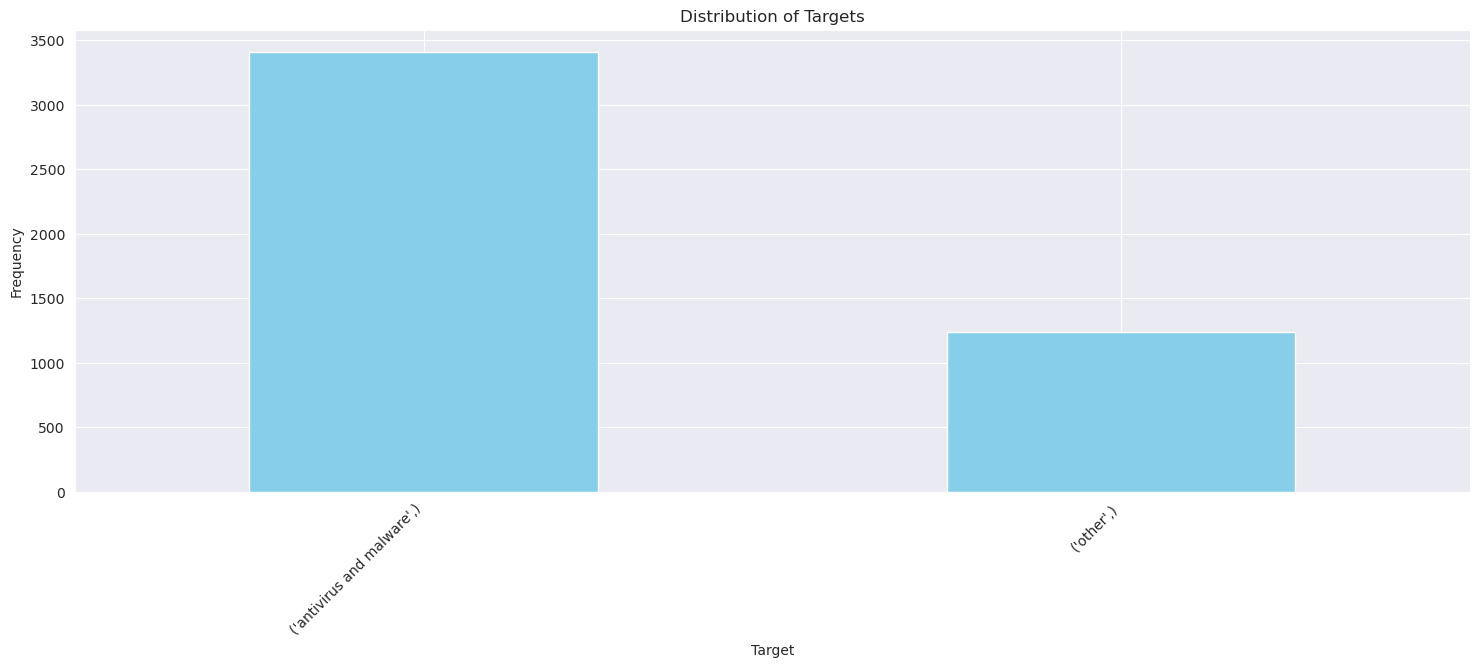

In [22]:
target_freq = Counter(tuple(item) for item in threat_tweets['target'])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.items()})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [23]:
# Multi-Label Analysis
multi_label_counts = threat_tweets['target'].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 0


In [24]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(threat_tweets['target'], threat_tweets['text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=['target', 'text'])

for target in class_freq:
    target_texts = target_text_df[target_text_df['target'].apply(func=lambda x: target in x)]['text']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'antivirus and malware':
ddos             888
vulnerability    742
attack           607
ransomware       459
injection        404
sql              386
exploit          339
new              287
botnet           252
attacker         246
dtype: int64
Top 10 words for target 'other':
vulnerability    1019
security          340
website            75
team               66
new                64
notify             60
service            59
cisco              56
hacker             56
denial             55
dtype: int64


## 5. Feature Engineering

In [25]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = threat_tweets[threat_tweets['target'].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df['target'])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('antivirus and malware',): 3412
('other',): 1241


Preprocess the `text` column into embeddings

In [27]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(
            x=list_str,
            embedder_addr=model_path,
            preprocessing_list=[replace_text_components, clean_text]
        )

    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = np.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)

        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str


texts = filtered_df['text']
x = preprocess_texts(
    list_str=texts,
    model_path='sentence-transformers/all-mpnet-base-v2',
    embedding_dim=None
)
#X = preprocess_texts(list_str=filtered_df['text'], model_path=GLOVE_6B_300D_TXT, embedding_dim=300)

Convert the `target` column into a binary multi-label matrix

In [28]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df['target'])

Create a dictionary that maps label indices to unique label sets

In [29]:
unique_label_sets, y_lp = np.unique(ar=y, axis=0, return_inverse=True)
label_map_lp = {i: tuple(lbl_set) for i, lbl_set in enumerate(unique_label_sets)}

Perform pruning and subsampling of the dataset to remove infrequent targets

In [30]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=x,
    y=y,
    pruning_threshold=np.median(np.array(list(target_freq.values()))) * .25,
    max_sub_samples=round(np.median(np.array(list(target_freq.values()))) * .25)
)

  0%|          | 0/4653 [00:00<?, ?it/s]

In [31]:
#smote = SMOTE(random_state=42)
#X, y_lp = smote.fit_resample(X, y_lp)
#y = np.array(unique_label_sets[y_lp])
#print(f"{X.shape}, {len(y_lp)}")

## 6. Model Training

In [32]:
# BR, CLR, CC, CDN, MBR, LP
X_train, X_val, y_train, y_val, y_train_lp, y_val_lp = train_test_split(
    x, y, y_lp,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_lp
)

print(
    f"{'Training:':<15}\tX = {str(X_train.shape[0]) + ' × ' + str(X_train.shape[1]):<15}\ty = {str(y_train.shape[0]) + ' × ' + str(y_train.shape[1]):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val.shape[0]) + ' × ' + str(X_val.shape[1]):<15}\ty = {str(y_val.shape[0]) + ' × ' + str(y_val.shape[1]):<15}")

Training:      	X = 3722 × 768     	y = 3722 × 2       
Validation:    	X = 931 × 768      	y = 931 × 2        


In [33]:
# PSt
X_train_pst, X_val_pst, y_train_pst, y_val_pst = train_test_split(
    X_pst, y_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_pst
)
print(
    f"{'Training:':<15}\tX = {str(X_train_pst.shape[0]) + ' × ' + str(X_train_pst.shape[1]):<15}\ty = {str(len(y_train_pst)):<15}")
print(
    f"{'Validation:':<15}\tX = {str(X_val_pst.shape[0]) + ' × ' + str(X_val_pst.shape[1]):<15}\ty = {str((len(y_val_pst))):<15}")

Training:      	X = 3722 × 768     	y = 3722           
Validation:    	X = 931 × 768      	y = 931            


### 4.1. Binary Problems


#### 4.1.1. BR (Binary Relevance)


In [34]:
if RETRAIN:
    for k in tqdm(BASE_CLASSIFIERS.keys()):
        br[k] = OneVsRestClassifier(estimator=BASE_CLASSIFIERS[k]).fit(X=X_train, y=y_train)

100%|██████████| 3/3 [00:23<00:00,  7.88s/it]


#### 4.1.2. CLR (Calibrated Label Ranking)


In [35]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = CalibratedLabelRankClassifier(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        clr[k] = model.fit(
            x=X_train,
            y=[list(mlb.classes_[np.where(row == 1)[0]]) for row in y_train]
        )

100%|██████████| 3/3 [00:45<00:00, 15.06s/it]


#### 4.1.3. CC (Classifier Chains)


In [36]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ChainOfClassifiers(
            classifier=v,
            classes=mlb.classes_,
            random_state=RANDOM_STATE
        )

        cc[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [00:24<00:00,  8.20s/it]


### 4.2. Multi-class Problems



#### 4.2.1. LP (Label Powerset)


In [37]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_lp,
            random_state=RANDOM_STATE
        )

        lp[k] = model.fit(
            x=X_train,
            y=y_train_lp
        )

100%|██████████| 3/3 [00:11<00:00,  3.88s/it]


#### 4.2.2. PSt (Pruned Sets)


In [38]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = LabelPowersetClassifier(
            classifier=v,
            label_map=label_map_pst,
            random_state=RANDOM_STATE
        )

        pst[k] = model.fit(
            x=X_train_pst,
            y=y_train_pst
        )

100%|██████████| 3/3 [00:11<00:00,  3.92s/it]


### 4.3. Ensembles


#### 4.3.1. CDN (Conditional Dependency Network)


In [39]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = ConditionalDependencyNetwork(
            classifier=v,
            num_iterations=100,
            burn_in=10
        )

        cdn[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [00:14<00:00,  4.71s/it]


#### 4.3.2. MBR (Meta-Binary Relevance)


In [40]:
if RETRAIN:
    for k, v in tqdm(BASE_CLASSIFIERS.items()):
        model = MetaBinaryRelevance(
            classifier=v,
            use_cross_val=True,
            n_splits=5
        )

        mbr[k] = model.fit(
            x=X_train,
            y=y_train
        )

100%|██████████| 3/3 [02:20<00:00, 46.67s/it]


## 7. Model Evaluation

In [41]:
performances = {}

### 7.1. Binary Problems



#### 7.1.1. BR (Binary Relevance)


In [42]:
performances['BR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=br,
    classes=mlb.classes_
)

In [43]:
y_val_hat = performances['BR']['Model'].predict(X_val)
print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.92      0.96      0.94       683
                other       0.88      0.77      0.82       248

            micro avg       0.91      0.91      0.91       931
            macro avg       0.90      0.87      0.88       931
         weighted avg       0.91      0.91      0.91       931
          samples avg       0.91      0.91      0.91       931

Accuracy:	0.9119
AUC:	0.8681


#### 7.1.2. CLR (Calibrated Label Ranking)


In [44]:
performances['CLR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=clr,
    classes=mlb.classes_
)

In [45]:
y_val_hat = performances['CLR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.94      0.95      0.94       683
                other       0.85      0.84      0.84       248

            micro avg       0.92      0.92      0.92       931
            macro avg       0.90      0.89      0.89       931
         weighted avg       0.92      0.92      0.92       931
          samples avg       0.92      0.92      0.92       931

Accuracy:	0.9173
AUC:	0.8923


#### 7.1.3. CC (Classifier Chains)


In [46]:
performances['CC'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cc,
    classes=mlb.classes_
)

In [47]:
y_val_hat = performances['CC']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.94      0.95      0.94       683
                other       0.85      0.84      0.84       248

            micro avg       0.92      0.92      0.92       931
            macro avg       0.90      0.89      0.89       931
         weighted avg       0.92      0.92      0.92       931
          samples avg       0.92      0.92      0.92       931

Accuracy:	0.9173
AUC:	0.8923


### 7.2. Multi-class Problems




#### 7.2.1. LP (Label Powerset)



In [48]:
performances['LP'] = assess_models(
    x=X_val,
    y=np.array([list(label_map_lp[yp]) for yp in y_val_lp]),
    technique=lp,
    classes=mlb.classes_
)

In [49]:
y_val_hat = performances['LP']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.92      0.96      0.94       683
                other       0.88      0.77      0.82       248

            micro avg       0.91      0.91      0.91       931
            macro avg       0.90      0.87      0.88       931
         weighted avg       0.91      0.91      0.91       931
          samples avg       0.91      0.91      0.91       931

Accuracy:	0.9119
AUC:	0.8681


#### 7.2.2. PSt (Pruned Sets)


In [50]:
performances['PST'] = assess_models(
    x=X_val_pst,
    y=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    technique=pst,
    classes=mlb.classes_
)

In [51]:
y_val_hat = performances['PST']['Model'].predict(X_val_pst)

print(classification_report(
    y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]),
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(
    f"Accuracy:\t{accuracy_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_pred=y_val_hat):.4f}")
try:
    print(
        f"AUC:\t{roc_auc_score(y_true=np.array([list(label_map_pst[yp]) for yp in y_val_pst]), y_score=y_val_hat):.4f}")
except ValueError:
    print(f"AUC:\tNot defined")

                       precision    recall  f1-score   support

antivirus and malware       0.90      0.97      0.93       683
                other       0.89      0.72      0.79       248

            micro avg       0.90      0.90      0.90       931
            macro avg       0.89      0.84      0.86       931
         weighted avg       0.90      0.90      0.90       931
          samples avg       0.90      0.90      0.90       931

Accuracy:	0.9001
AUC:	0.8420


### 7.3. Ensembles


#### 7.3.1. CDN (Conditional Dependency Network)


In [52]:
performances['CDN'] = assess_models(
    x=X_val,
    y=y_val,
    technique=cdn,
    classes=mlb.classes_
)

In [53]:
y_val_hat = performances['CDN']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.88      0.90      0.89       683
                other       0.66      0.66      0.66       248

            micro avg       0.83      0.83      0.83       931
            macro avg       0.77      0.78      0.78       931
         weighted avg       0.82      0.83      0.83       931
          samples avg       0.79      0.83      0.81       931

Accuracy:	0.7540
AUC:	0.7773


#### 7.3.2. MBR (Meta-Binary Relevance)


In [54]:
performances['MBR'] = assess_models(
    x=X_val,
    y=y_val,
    technique=mbr,
    classes=mlb.classes_
)

In [55]:
y_val_hat = performances['MBR']['Model'].predict(X_val)

print(classification_report(
    y_true=y_val,
    y_pred=y_val_hat,
    target_names=mlb.classes_,
    zero_division=0
))
print(f"Accuracy:\t{accuracy_score(y_true=y_val, y_pred=y_val_hat):.4f}")
print(f"AUC:\t{roc_auc_score(y_true=y_val, y_score=y_val_hat):.4f}")

                       precision    recall  f1-score   support

antivirus and malware       0.93      0.96      0.95       683
                other       0.89      0.81      0.85       248

            micro avg       0.92      0.92      0.92       931
            macro avg       0.91      0.88      0.90       931
         weighted avg       0.92      0.92      0.92       931
          samples avg       0.92      0.92      0.92       931

Accuracy:	0.9216
AUC:	0.8863


## 8. Summary


In [56]:
performances = pd.DataFrame(performances).T
performances

,Accuracy,Classifier,Model,Precision example-based,Recall example-based,F1 example-based,Hamming loss,Micro precision,Micro recall,Micro F1,Macro precision,Macro recall,Macro F1,Coverage,Classification
BR,0.911923,xgb,OneVsRestClassifier(estimator=XGBClassifier(ba...,0.911923,0.911923,0.911923,0.088077,0.911923,0.911923,0.911923,0.901096,0.868063,0.882648,1.088077,precision recall f1...
CLR,0.917293,xgb,CalibratedLabelRankClassifier(classes=array(['...,0.917293,0.917293,0.917293,0.082707,0.917293,0.917293,0.917293,0.895335,0.892268,0.893784,1.082707,precision recall f1...
CC,0.917293,xgb,ChainOfClassifiers(classes=array(['antivirus a...,0.917293,0.917293,0.917293,0.082707,0.917293,0.917293,0.917293,0.895335,0.892268,0.893784,1.082707,precision recall f1...
LP,0.911923,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.911923,0.911923,0.911923,0.088077,0.911923,0.911923,0.911923,0.901096,0.868063,0.882648,1.088077,precision recall f1...
PST,0.900107,xgb,LabelPowersetClassifier(classifier=XGBClassifi...,0.900107,0.900107,0.900107,0.099893,0.900107,0.900107,0.900107,0.894841,0.842033,0.863528,1.099893,precision recall f1...
CDN,0.7884,random_forest,ConditionalDependencyNetwork(classifier=Random...,0.823308,0.858217,0.834945,0.154672,0.836649,0.858217,0.847296,0.790506,0.808347,0.79931,1.2116,precision recall f1...
MBR,0.92159,random_forest,MetaBinaryRelevance(classifier=RandomForestCla...,0.92159,0.92159,0.92159,0.077336,0.923574,0.92159,0.922581,0.913095,0.884924,0.897792,1.07841,precision recall f1...


In [58]:
if OVERWRITE:
    joblib.dump(br, BR_PKL, compress=9)
    joblib.dump(clr, CLR_PKL, compress=9)
    joblib.dump(cc, CC_PKL, compress=9)
    joblib.dump(lp, LP_PKL, compress=9)
    joblib.dump(pst, PST_PKL, compress=9)
    joblib.dump(cdn, CDN_PKL, compress=9)
    joblib.dump(mbr, MBR_PKL, compress=9)

In [65]:
max_f1_score = 0.
optimal_model = None
for _, performance in performances.iterrows():
    if max_f1_score < performance['Macro F1']:
        max_f1_score = performance['Macro F1']
        optimal_model = performance['Model']

#if OVERWRITE:
joblib.dump(optimal_model, f'models/fine_grained_{MODEL_LEVEL}.pkl', compress=9)

optimal_model

MetaBinaryRelevance(classifier=RandomForestClassifier(class_weight='balanced',
                                                      random_state=42),
                    use_cross_val=True)

In [66]:
z = joblib.load(filename=f'models/fine_grained_{MODEL_LEVEL}.pkl')
type(z)

utils.MetaBinaryRelevance